In [77]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from itertools import chain
from sklearn.metrics import classification_report


In [78]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17073663530533735650
]
Num GPUs Available:  0


In [79]:
df = pd.read_csv('C:/Users/Rasmu/Downloads/ner_dataset.csv', encoding = "unicode-escape", error_bad_lines=False)
df = df[:600000]
df = df.fillna(method='ffill')

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


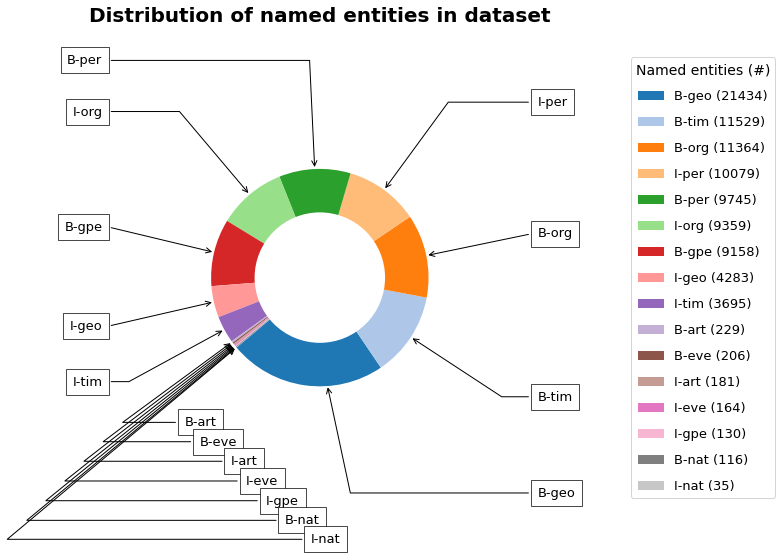

In [80]:
tag_plot = df[df["Tag"]!="O"]["Tag"].value_counts()

#https://matplotlib.org/devdocs/gallery/pie_and_polar_charts/pie_and_donut_labels.html

with plt.style.context({"axes.prop_cycle" : plt.cycler("color", plt.cm.tab20.colors)}):
    fig1 = plt.figure( figsize=[10,5])
    ax1 = fig1.add_subplot(111, aspect='equal')

    wedges, texts = ax1.pie(tag_plot.values, startangle=-140, radius=1)

    bbox_props = dict(boxstyle="square,pad=0.5", fc="w", ec="k", lw=0.7)
    kw = dict(arrowprops=dict(arrowstyle="->"),
          bbox=bbox_props, zorder=0, va="center")

    shift = [0,0,0,0,0,0,0,0,0,10, 20, 30, 40, 50, 60, 70]

    for i, p in enumerate(wedges):

        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        if(i == 0):
            ang = ang + 20
            x = x * -0.5

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})

        if(i < 9):
            ax1.annotate(tag_plot.index[i], xy=(x, y), xytext=(2*np.sign(x), 2*y), size=13,
                    horizontalalignment=horizontalalignment, **kw)

        if(i > 8):
            ax1.annotate(tag_plot.index[i], xy=(x, y), xytext=(-i/7+shift[i]/30, 2*i/8*y), size=13,
                    horizontalalignment=horizontalalignment, **kw)

    
    centre_circle = plt.Circle((0,0),0.60,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    legend_label = []

    for i, x in enumerate(tag_plot):
        legend_label.append(tag_plot.index[i] + " " + "(" + str(tag_plot.values[i]) + ")")

    plt.legend(legend_label,bbox_to_anchor=(2.2,0.5), loc="center right", fontsize=13, title='Named entities (#)', title_fontsize=14, labelspacing = 1)
    plt.title('Distribution of named entities in dataset', fontweight="bold", size=20, pad=120.0)
    plt.show()

In [81]:
#Create mapper for features

tag_vocab = np.unique(df['Tag']).tolist()
tag_vocab = sorted(tag_vocab, key=lambda x : x.split("-")[-1])

word_vocab = np.unique(df['Word']).tolist()
word_vocab.insert(0, '<PAD>')

i_to_word = {i:word for  i, word in enumerate(word_vocab)}
word_to_i = {word:i for  i, word in enumerate(word_vocab)}

i_to_tag = {i:tag for  i, tag in enumerate(tag_vocab)}
tag_to_i = {tag:i for  i, tag in enumerate(tag_vocab)}

In [82]:
#Append index columns for words and tags and group dataframe by sentence

df['Word_index'] = df['Word'].map(word_to_i)
df['Tag_index'] = df['Tag'].map(tag_to_i)

df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))
df_grouped.head()

C:\Users\Rasmu\AppData\Local\Temp/ipykernel_8936/638383492.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))


,Sentence #,Word,POS,Tag,Word_index,Tag_index
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[10902, 20938, 15577, 18167, 19936, 25604, 693...","[0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[5906, 20961, 23685, 25525, 16879, 25661, 1778...","[7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[5459, 18035, 9792, 21928, 20200, 18272, 18665...","[0, 0, 15, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 11..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[10883, 19492, 12263, 11971, 25441, 18454, 247...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[11155, 23003, 14996, 6069, 4191, 23621, 10561...","[5, 0, 0, 13, 14, 0, 15, 0, 5, 0, 7, 0, 7, 0, ..."


In [83]:
max_tag = len(tag_vocab)
max_word = len(word_vocab)

tokens = df_grouped['Word_index'].tolist()
tags = df_grouped['Tag_index'].tolist()

max_length = max([len(s) for s in tokens])

pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding='post', value=max_length - 1)

pad_tags = pad_sequences(tags, maxlen=max_length, dtype='int32', padding='post', value= tag_to_i["O"])
n_tags = len(tag_to_i)
pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.4, random_state=42)

In [84]:
input_dim = len(word_vocab)+1
output_dim = 128
input_length = max([len(s) for s in df_grouped['Word_index'].tolist()])

In [85]:
root_logdir = os.path.join(os.curdir, "../logged_models/bidir_lstm")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

In [86]:
#https://keras.io/examples/nlp/text_classification_with_transformer/

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [87]:
inputs = layers.Input(shape=(input_length,))
embedding_layer = TokenAndPositionEmbedding(input_length, input_dim, output_dim)
x = embedding_layer(inputs)

transformer_block = TransformerBlock(output_dim, 2, 32)
x = transformer_block(x)

x = layers.MaxPooling1D(pool_size=1)(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(17, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [88]:

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#Hyper params to change - learning rate, number of layers and neurons, activations functions

#TOKENIZER AND MASKING PADDINGS

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 
model.summary()
plot_model(model)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 104)]             0         
_________________________________________________________________
token_and_position_embedding (None, 104, 128)          3473024   
_________________________________________________________________
transformer_block_9 (Transfo (None, 104, 128)          140832    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 104, 128)          0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 104, 128)          0         
_________________________________________________________________
dense_36 (Dense)             (None, 104, 20)           2580      
_________________________________________________________________
dropout_37 (Dropout)         (None, 104, 20)           0   

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [89]:
#Run in command line
#tensorboard --logdir=C:\Users\Rasmu\Documents\Repos\BAC\Ezra\linguistic\logged_models --port=8888

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(train_tokens, np.array(train_tags), epochs=25, callbacks=[tensorboard_cb, earlystopping, lr_scheduler], validation_split=0.2)


Epoch 1/25
412/412 [==============================] - 69s 164ms/step - loss: 0.1350 - accuracy: 0.9688 - val_loss: 0.0802 - val_accuracy: 0.9765
Epoch 2/25
412/412 [==============================] - 65s 157ms/step - loss: 0.0694 - accuracy: 0.9796 - val_loss: 0.0707 - val_accuracy: 0.9815
Epoch 3/25
412/412 [==============================] - 50s 122ms/step - loss: 0.0593 - accuracy: 0.9836 - val_loss: 0.0727 - val_accuracy: 0.9802
Epoch 4/25
412/412 [==============================] - 64s 156ms/step - loss: 0.0547 - accuracy: 0.9849 - val_loss: 0.0695 - val_accuracy: 0.9821
Epoch 5/25
412/412 [==============================] - 45s 110ms/step - loss: 0.0525 - accuracy: 0.9855 - val_loss: 0.0666 - val_accuracy: 0.9827
Epoch 6/25
412/412 [==============================] - 46s 112ms/step - loss: 0.0504 - accuracy: 0.9861 - val_loss: 0.0657 - val_accuracy: 0.9828
Epoch 7/25
412/412 [==============================] - 45s 109ms/step - loss: 0.0488 - accuracy: 0.9865 - val_loss: 0.0663 - val_ac

In [90]:
y_pred = model.predict(test_tokens) #Calculates probability for each tag

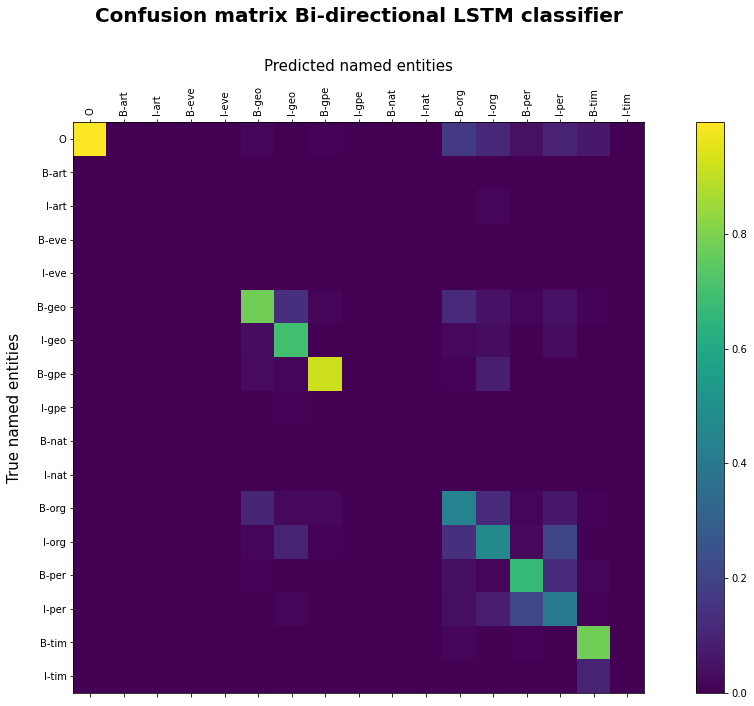

In [91]:
y_classes = y_pred.argmax(axis=-1)

cm_true = np.array(test_tags).argmax(axis=-1).flatten()
cm_pred = y_classes.flatten()

cm = confusion_matrix(cm_true, cm_pred, normalize='pred')
fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted named entities', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True named entities', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(len(tag_vocab)), tag_vocab, rotation=90)
plt.yticks(range(len(tag_vocab)), tag_vocab)
plt.show()

In [92]:
report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:17]
df_perf_2.insert(loc=0, column='Tag', value=tag_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rasmu\anaconda3\envs\LA\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rasmu\anaconda3\envs\L

,Tag,precision,recall,f1-score,support
0,O,0.99,1.00,1.00,1104101.0
1,B-art,0.00,0.00,0.00,87.0
2,I-art,0.00,0.00,0.00,85.0
3,B-eve,0.00,0.00,0.00,90.0
4,I-eve,0.00,0.00,0.00,76.0
5,B-geo,0.78,0.77,0.78,8562.0
6,I-geo,0.69,0.48,0.57,1626.0
7,B-gpe,0.92,0.88,0.90,3626.0
8,I-gpe,0.00,0.00,0.00,44.0
9,B-nat,0.00,0.00,0.00,45.0


In [93]:
unique_classes = []

for i in cm_true:
    unique_classes.append(i_to_tag[i])

set(unique_classes)

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}